**Important: This notebook will only work with fastai-0.7.x. Do not try to run any fastai-1.x code from this path in the repository because it will load fastai-0.7.x**

# Fisheries competition

In this notebook we're going to investigate a range of different techniques for the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring). In this competition, The Nature Conservancy asks you to help them detect which species of fish appears on a fishing boat, based on images captured from boat cameras of various angles. Your goal is to predict the likelihood of fish species in each picture. Eight target categories are available in this dataset: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other 

You can use [this](https://github.com/floydwch/kaggle-cli) api to download the data from Kaggle.

In [ ]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.plots import *
from fastai.io import get_data

PATH = "data/fish/"

## First look at fish pictures

In [ ]:
!ls {PATH}

In [ ]:
!ls {PATH}train

In [ ]:
files = !ls {PATH}train/ALB | head
files

In [ ]:
img = plt.imread(f'{PATH}train/ALB/{files[0]}')
plt.imshow(img);

## Data pre-processing

Here we are changing the structure of the training data to make it more convinient. We will have all images in a common directory `images` and will have a file `train.csv` with all labels. 

In [ ]:
from os import listdir
from os.path import join
train_path = f'{PATH}/train'

In [ ]:
dirs = [d for d in listdir(train_path) if os.path.isdir(join(train_path,d))]
print(dirs)

In [ ]:
train_dict = {d: listdir(join(train_path, d)) for d in dirs}

In [ ]:
train_dict["LAG"][:10]

In [ ]:
sum(len(v) for v in train_dict.values())

In [ ]:
with open(f"{PATH}train.csv", "w") as csv:
    csv.write("img,label\n")
    for d in dirs:
        for f in train_dict[d]: csv.write(f'{f},{d}\n')

In [ ]:
img_path = f'{PATH}images'
os.makedirs(img_path, exist_ok=True)

In [ ]:
!cp {PATH}train/*/*.jpg {PATH}images/

## Our first model with Center  Cropping

Here we import the libraries we need. We'll learn about what each does during the course.

In [ ]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *

In [ ]:
sz=350
bs=64
csv_fname = os.path.join(PATH, "train.csv")
train_labels = list(open(csv_fname))
n = len(list(open(csv_fname)))-1
val_idxs = get_cv_idxs(n)

In [ ]:
tfms = tfms_from_model(resnet34, sz)
data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs)

In [ ]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam, ps=0.5)

models are fine
supper init
  0%|          | 0/48 [00:00<?, ?it/s]torch.Size([64, 3, 350, 350])



RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1502009910772/work/torch/lib/THC/generic/THCStorage.cu:66

 65%|██████▍   | 31/48 [00:00<00:03,  4.59it/s, loss=2.07]


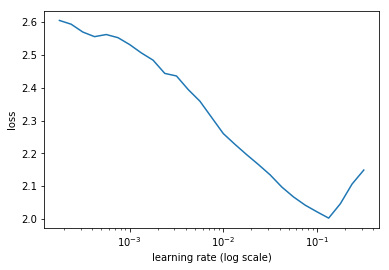

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
learn.fit(0.01, 4, cycle_len=1, cycle_mult=2)

[ 0.      0.6912  0.617   0.7949]                         
[ 1.      0.6748  0.3572  0.8928]                          
[ 2.      0.5156  0.3283  0.8974]                          
[ 3.      0.4837  0.3402  0.8873]                          
[ 4.      0.4303  0.2782  0.9179]                          
[ 5.      0.3515  0.2209  0.9267]                          
[ 6.      0.2841  0.2082  0.9349]                          
[ 7.      0.318   0.2482  0.9287]                          
[ 8.      0.3518  0.2316  0.9323]                          
[ 9.      0.3343  0.2133  0.9323]                         
[ 10.       0.2857   0.2128   0.9293]                      
[ 11.       0.2414   0.2148   0.9349]                      
[ 12.       0.2077   0.189    0.9287]                      
[ 13.       0.1834   0.1826   0.9352]                      
[ 14.       0.162    0.179    0.9391]                      



 79%|███████▉  | 38/48 [00:24<00:05,  1.89it/s, loss=1.48] 

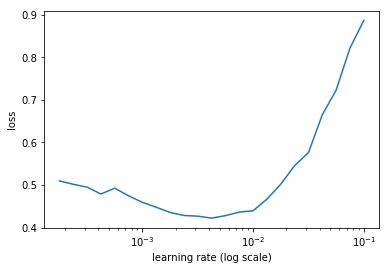

In [ ]:
lrs=np.array([1e-4,1e-3,1e-2])
learn.precompute=False

learn.freeze_to(6)
lrf=learn.lr_find(lrs/1e3)
learn.sched.plot()

## Same model with No cropping 

NOTE: Before running this remove the temp file under data/fish.

In [ ]:
sz = 350
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO)
data = ImageClassifierData.from_csv(PATH, "images", csv_fname, bs, tfms, val_idxs)

In [ ]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam, ps=0.5)

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1502009910772/work/torch/lib/THC/generic/THCStorage.cu:66

 56%|█████▋    | 27/48 [00:00<00:02, 10.40it/s, loss=2.16]


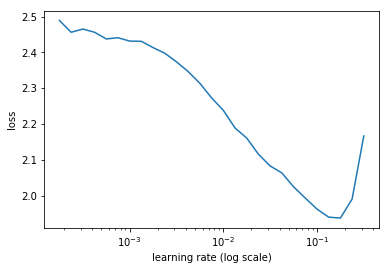

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
learn.fit(0.01, 4, cycle_len=1, cycle_mult=2)

[ 0.      0.682   0.5775  0.8251]                         
[ 1.      0.6791  0.3741  0.8824]                          
[ 2.      0.5242  0.3172  0.9056]                          
[ 3.      0.4669  0.2973  0.8942]                         
[ 4.      0.4197  0.2335  0.9238]                          
[ 5.      0.3512  0.2161  0.9277]                          
[ 6.      0.2884  0.181   0.9306]                          
[ 7.      0.3255  0.2539  0.9176]                          
[ 8.      0.3452  0.2123  0.9284]                          
[ 9.      0.317   0.2007  0.9371]                          
[ 10.       0.2644   0.1644   0.9557]                      
[ 11.       0.2244   0.1454   0.9528]                      
[ 12.       0.1818   0.1343   0.9665]                      
[ 13.       0.1599   0.1404   0.9599]                      
[ 14.       0.1546   0.1408   0.9586]                      



 79%|███████▉  | 38/48 [00:36<00:07,  1.25it/s, loss=1.65] 

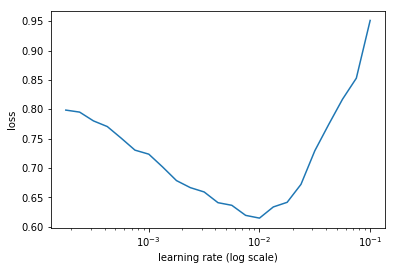

In [ ]:
lrs=np.array([1e-4,1e-3,1e-2])
learn.precompute=False

learn.unfreeze()
lrf=learn.lr_find(lrs/1e3)
learn.sched.plot()

In [ ]:
lrs=np.array([1e-5,1e-4,1e-3])
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

                                                          
                                                          
                                                          
                                                          

                                                          
                                                          

                                                          

  8%|▊         | 4/48 [00:08<01:49,  2.50s/it, loss=0.754]
[ 0.      0.2649  0.1643  0.9404]                          
[ 1.      0.1998  0.1073  0.9681]                          
[ 2.      0.1288  0.1007  0.9694]                          
[ 3.      0.0923  0.1089  0.9736]                           
[ 4.      0.0843  0.1173  0.971 ]                           
[ 5.      0.0549  0.1002  0.9694]                           
[ 6.      0.0396  0.0964  0.9733]                           
[ 7.      0.0315  0.1249  0.9762]                           
[ 8.      0.0382  0.1132  0.9746]       

## Predicting bounding boxes

### Getting bounding boxes data

This part needs to run just the first time to get the file `trn_bb_labels`

In [ ]:
import json
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [ ]:
def get_annotations():
    annot_urls = [
        '5458/bet_labels.json', '5459/shark_labels.json', '5460/dol_labels.json',
        '5461/yft_labels.json', '5462/alb_labels.json', '5463/lag_labels.json'
    ]
    cache_subdir = os.path.abspath(os.path.join(PATH, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    os.makedirs(cache_subdir, exist_ok=True)
    
    for url_suffix in annot_urls:
        fname = url_suffix.rsplit('/', 1)[-1]
        get_data(url_prefix + url_suffix, f'{cache_subdir}/{fname}')

In [ ]:
# run this code to get annotation files
get_annotations()

In [ ]:
# creates a dictionary of all annotations per file
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open(f'{PATH}annos/{c}_labels.json', 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]
bb_json['img_04908.jpg']

In [ ]:
raw_filenames = pd.read_csv(csv_fname)["img"].values

In [ ]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}

empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb):
    bb = [bb[p] for p in bb_params]
    bb[2] = max(bb[2], 0)
    bb[3] = max(bb[3], 0)
    return bb

In [ ]:
trn_bbox = np.stack([convert_bb(bb_json[f]) for f in raw_filenames]).astype(np.float32)
trn_bb_labels = [f + ',' + ' '.join(map(str,o))+'\n' for f,o in zip(raw_filenames,trn_bbox)]

In [ ]:
open(f'{PATH}trn_bb_labels', 'w').writelines(trn_bb_labels)

In [ ]:
fnames,csv_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_labels', skip_header=False)

In [ ]:
def bb_corners(bb):
    bb = np.array(bb, dtype=np.float32)
    row1 = bb[3]
    col1 = bb[2]
    row2 = row1 + bb[0]
    col2 = col1 + bb[1]
    return [row1, col1, row2, col2]

In [ ]:
f = 'img_02642.jpg'
bb = csv_labels[f]
print(bb)
bb_corners(bb)

In [ ]:
new_labels = [f + "," + " ".join(map(str, bb_corners(csv_labels[f]))) + "\n" for f in raw_filenames]

In [ ]:
open(f'{PATH}trn_bb_corners_labels', 'w').writelines(new_labels)

### Looking at bounding boxes

In [ ]:
# reading bb file
bbox = {}
bb_data = pd.read_csv(f'{PATH}trn_bb_labels', header=None)

In [ ]:
fnames,csv_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_labels', skip_header=False)
fnames,corner_labels,_,_ = parse_csv_labels(f'{PATH}trn_bb_corners_labels', skip_header=False)

In [ ]:
corner_labels["img_06297.jpg"]

['396.21', '404.67', '504.78', '623.22']

In [ ]:
csv_labels["img_06297.jpg"]

['108.57', '218.55', '404.67', '396.21']

In [ ]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(path, f='img_04908.jpg'):
    file_path = f'{path}images/{f}'
    bb = csv_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_rect(bb))

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def show_corner_bb(path, f='img_04908.jpg'):
    file_path = f'{path}images/{f}'
    bb = corner_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_corner_rect(bb))

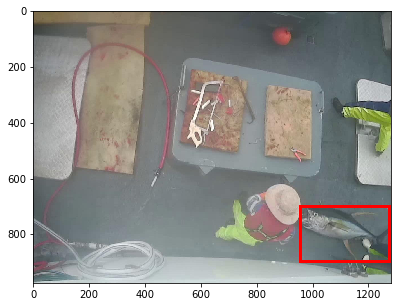

In [ ]:
show_corner_bb(PATH, f = 'img_02642.jpg')

### Model predicting bounding boxes

In [ ]:
sz=299
bs=64

label_csv=f'{PATH}trn_bb_corners_labels'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [ ]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)
data = ImageClassifierData.from_csv(PATH, 'images', label_csv, tfms=tfms, val_idxs=val_idxs,
                                    continuous=True, skip_header=False)

In [ ]:
trn_ds = data.trn_dl.dataset

In [ ]:
x, y = trn_ds[0]

In [ ]:
print(x.shape, y)

(3, 299, 299) [ 56  62 163 150]


In [ ]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True, opt_fn=optim.Adam, ps=0.5)

  0%|          | 0/48 [00:00<?, ?it/s]

KeyboardInterrupt: 





  0%|          | 0/48 [00:00<?, ?it/s]



                                                         







[    0.       234.0974  4450.0396]


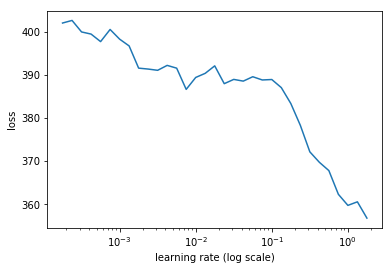

In [ ]:
lrf=learn.lr_find()
learn.sched.plot()

In [ ]:
learn.fit(0.01, 5, cycle_len=1, cycle_mult=2)




  0%|          | 0/48 [00:00<?, ?it/s]




                                                         







[   0.      238.681   364.7433]




  0%|          | 0/48 [00:00<?, ?it/s]



                                                         







[   1.      263.2261  186.7536]




  0%|          | 0/48 [00:00<?, ?it/s]



                                                         







[   2.      210.889   168.2116]




  0%|          | 0/48 [00:00<?, ?it/s]



                                                         







[   3.      176.0693  144.2513]




  0%|          | 0/48 [00:00<?, ?it/s]



                                                         







[   4.      151.4565  129.4032]




  0%|          | 0/48 [00:00<?, ?it/s]



                                                         







[   5.      138.8294  123.4013]



  0%|          | 0/48 [00:00<?, ?it/s]




                                                         







[   6.      131.2182  122.3169]

[  0.0000e+00   1.3241e+02   3.5670e+13]                 



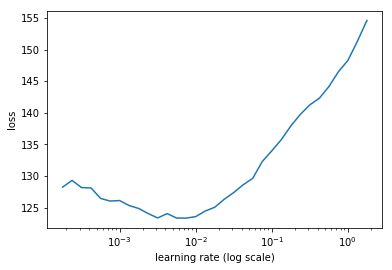

In [ ]:
lrs=np.array([1e-4,1e-3,1e-2])
learn.precompute=False

learn.unfreeze()
lrf=learn.lr_find(lrs/1e3)
learn.sched.plot()

In [ ]:
lrs=np.array([1e-5,1e-4,1e-3])
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

[  0.      71.1009  94.999 ]                             
[  1.      88.0754  82.1335]                             
[  2.      87.4359  77.1687]                              
[  3.      86.5974  80.8263]                              
[  4.      83.9792  71.4977]                              
[  5.      79.1773  69.3897]                              
[  6.      77.2359  68.047 ]                              
[  7.      77.6487  77.4456]                              
[  8.      78.9041  73.7645]                              
[  9.      75.8422  68.0503]                              
[ 10.      73.4623  64.6083]                              
[ 11.      72.2943  63.5834]                              
[ 12.      70.4287  62.1409]                              
[ 13.      66.5874  59.9783]                              
[ 14.      66.0414  60.785 ]                              
[ 15.      66.3314  65.7976]                              
[ 16.      69.3549  65.7114]                              

## Looking into size of images

In [ ]:
f="img_06297.jpg"
PIL.Image.open(PATH+"images/" + f).size

In [ ]:
sizes = [PIL.Image.open(PATH+f).size for f in data.trn_ds.fnames]
raw_val_sizes = [PIL.Image.open(PATH+f).size for f in data.val_ds.fnames]